In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from tqdm.notebook import tqdm, trange

In [4]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.n_qubits=n_qubits
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.cnot(0,1)
        self._circuit.cnot(2,3)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts(self._circuit)


               
        counts = np.array(list(result.values()))

        states_str= np.array(list(result.keys())).astype(str)
        states = np.array(list(result.keys())).astype(float)      

        stateLength=len(states_str[0])


        expectations=[0]*self.n_qubits
    

        for j in range(len(states_str[0])):    
            for idx,k in enumerate(states_str): 
            
                if k[j]=='1':
                    expectations[j]=expectations[j]+counts[idx]
         
        expectations=np.array(expectations)
        probabilities=expectations/self.shots

        
        return probabilities
    

C:\Users\joshr\anaconda3\lib\site-packages\qiskit\result\result.py:371: UserWarning: Result object contained multiple results matching name "circuit85", only first match will be returned. Use an integer index to retrieve results for all entries.
  'retrieve results for all entries.' % key)
Expected value for rotation pi [0.523 0.502 0.475 0.493]


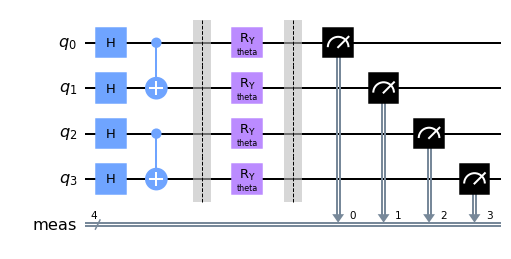

In [5]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(4, simulator, 1000)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi, np.pi, np.pi, np.pi])))
circuit._circuit.draw(output="mpl", filename="twoQuibitCircuit.jpg")

In [6]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        #print("the input is", input)
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        #print("the z expectation is", expectation_z)
        
        result = torch.tensor([expectation_z])
        #print("the result is", result)
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        #print("the input is:", input)
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        #print("the shift right is", shift_right)
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        #print("the shift left is", shift_left)
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            #print("expectation right is:", expectation_right)
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            #print("gradient is:" ,gradient)
            #print("gradient size", gradient.shape)
            gradients.append(gradient.tolist())
        #print("gradients is ", gradients)
        #print("grad_output is:", grad_output)
        gradients=np.array(gradients).T
        return torch.tensor(gradients, dtype=torch.float) * grad_output, None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(4, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [7]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
num=4
idx = np.where(X_train.targets == 0)[0][:n_samples]
for i in range(num):
    if i!=0:
        idx = np.append(idx,np.where(X_train.targets == i)[0][:n_samples])
        



X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [8]:
idx

array([   1,   21,   34,   37,   51,   56,   63,   68,   69,   75,   81,
         88,   95,  108,  114,  118,  119,  121,  156,  169,  192,  206,
        209,  210,  216,  229,  232,  234,  246,  249,  260,  283,  293,
        296,  303,  320,  326,  359,  399,  427,  429,  435,  440,  451,
        453,  458,  462,  464,  473,  489,  519,  524,  526,  527,  542,
        577,  582,  596,  603,  612,  633,  639,  656,  662,  666,  667,
        668,  669,  689,  702,  709,  712,  733,  743,  745,  776,  781,
        787,  790,  818,  825,  849,  859,  860,  869,  872,  889,  903,
        927,  943,  949,  952,  957,  965,  979,  984,  997, 1000, 1015,
       1018,    3,    6,    8,   14,   23,   24,   40,   59,   67,   70,
         72,   77,   78,   99,  102,  104,  105,  112,  113,  124,  128,
        134,  152,  174,  177,  184,  200,  201,  205,  208,  211,  224,
        231,  248,  251,  269,  270,  276,  290,  309,  310,  315,  345,
        351,  355,  357,  358,  366,  382,  394,  3

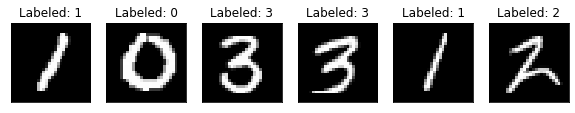

In [9]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = next(data_iter)

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [10]:
targets[0].item()

1

In [11]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

num=4
idx = np.where(X_test.targets == 0)[0][:n_samples]
for i in range(num):
    if i!=0:
        idx = np.append(idx,np.where(X_test.targets == i)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

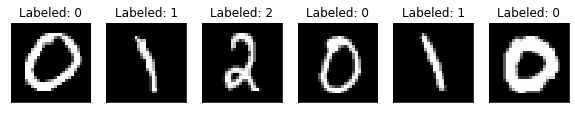

In [12]:
n_samples_show = 6

data_iter = iter(test_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = next(data_iter)

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [13]:
mean = (0.5,)
std_dev = (0.5,)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 4)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = self.dropout(x)
        x = x.view(1, -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print ("the ouput of the classical network is: %d", x); 
        x = self.hybrid(x)
       
        #print ("the ouput of the hybrid network is: %d", x); 
        return x

In [15]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []


model.train()
for epoch in range(epochs):
    progress_bar = tqdm(train_loader, ncols=1000)
    total_loss = []
    for batch_idx, (data, target) in enumerate(progress_bar):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
       
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

C:\Users\joshr\anaconda3\lib\site-packages\qiskit\result\result.py:371: UserWarning: Result object contained multiple results matching name "circuit87", only first match will be returned. Use an integer index to retrieve results for all entries.
  'retrieve results for all entries.' % key)

Training [5%]	Loss: 1.3897



Training [10%]	Loss: 1.3893



Training [15%]	Loss: 1.3856



Training [20%]	Loss: 1.3878



Training [25%]	Loss: 1.3869



Training [30%]	Loss: 1.3882



Training [35%]	Loss: 1.3865



Training [40%]	Loss: 1.3856



Training [45%]	Loss: 1.3859



Training [50%]	Loss: 1.3865



Training [55%]	Loss: 1.3874



Training [60%]	Loss: 1.3863



Training [65%]	Loss: 1.3873



Training [70%]	Loss: 1.3866



Training [75%]	Loss: 1.3864



Training [80%]	Loss: 1.3861



Training [85%]	Loss: 1.3874



Training [90%]	Loss: 1.3841



Training [95%]	Loss: 1.3866



Training [100%]	Loss: 1.3884


Text(0, 0.5, 'Neg Log Likelihood Loss')

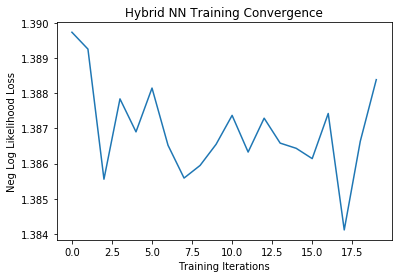

In [17]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [18]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

C:\Users\joshr\anaconda3\lib\site-packages\qiskit\result\result.py:371: UserWarning: Result object contained multiple results matching name "circuit87", only first match will be returned. Use an integer index to retrieve results for all entries.
  'retrieve results for all entries.' % key)
Performance on test data:
	Loss: 1.3874
	Accuracy: 22.0%


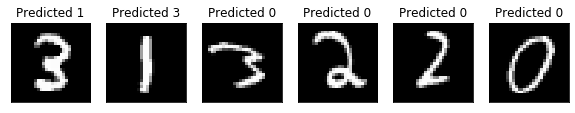

In [19]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1